##RESNET Model


## Importing necessary libraries

In [1]:
import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import tensorflow as tf
import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

c:\Users\Jayasri Rajan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# General parameters
epochs = 20
image_size = 240
np.random.seed(42)
tf.random.set_seed(42)

os.listdir("OralCancer")

folder_path = "OralCancer"

In [3]:
def load_and_process_dataset(folder_path):
    """Loads and processes images using alternative while loop structures."""

    dataset = []
    labels = []
    class_folders = ['non-cancer', 'cancer']

    class_index = 0
    while class_index < len(class_folders):
        class_folder = class_folders[class_index]
        images_path = os.path.join(folder_path, class_folder)

        image_index = 0
        while True:  # Loop infinitely until a "break" occurs
            try:
                image_name = os.listdir(images_path)[image_index]  # Access by index
                image_path = os.path.join(images_path, image_name)

                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
                image = cv2.resize(image, (240, 240))

                dataset.append(image)
                labels.append(class_index)  # Use class_index directly for labels

                image_index += 1
            except IndexError:  # Handle end of image list
                break  # Exit the inner loop

        class_index += 1

    return np.array(dataset), np.array(labels)

In [4]:
# Load dataset
dataset, labels = load_and_process_dataset(folder_path)


In [5]:
# Print shapes
print(dataset.shape, labels.shape)

(132, 240, 240, 3) (132,)


In [6]:
# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(np.array(dataset), np.array(labels), test_size=0.2, shuffle=True, random_state=42)


In [7]:
def plot_state(state):
    images = [load_img(os.path.join(folder_path, state, img_name), target_size=(image_size, image_size))
              for img_name in os.listdir(os.path.join(folder_path, state))[:9]]

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for ax, img in zip(axes.flat, images):
        ax.imshow(img)
    plt.show()

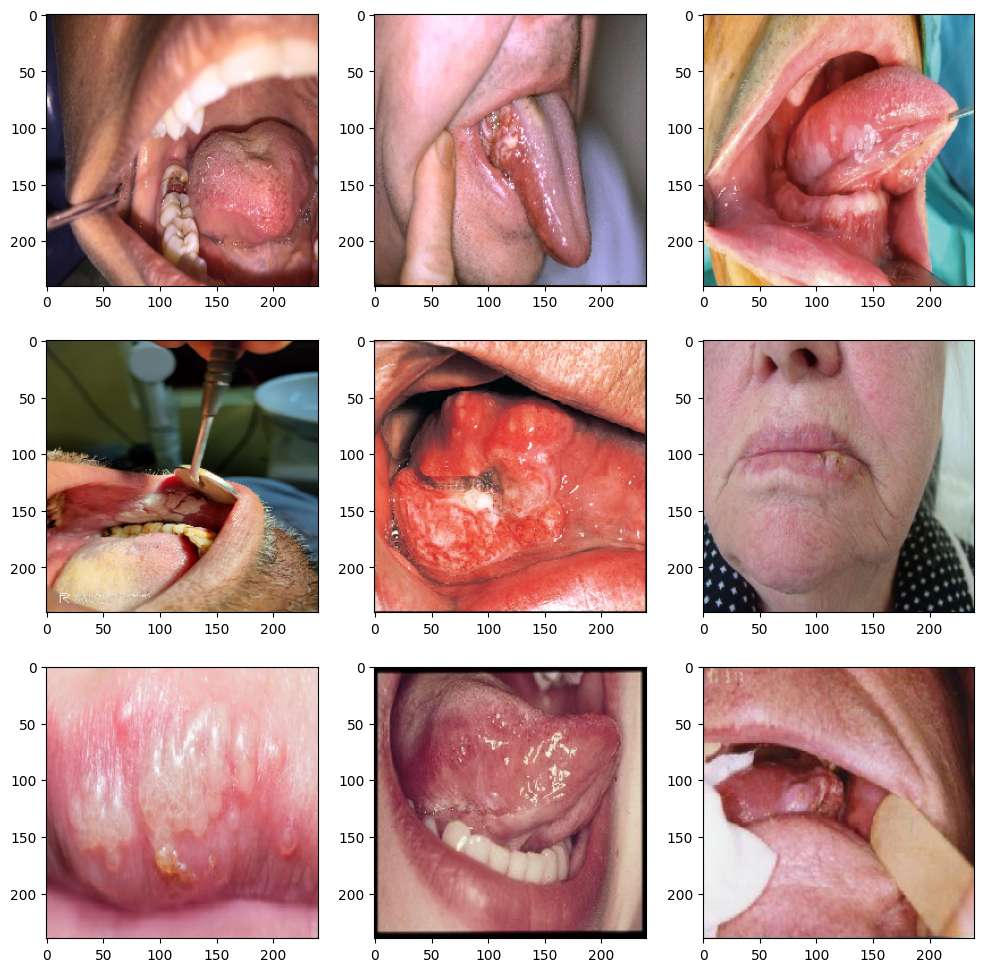

In [8]:

plot_state('cancer')


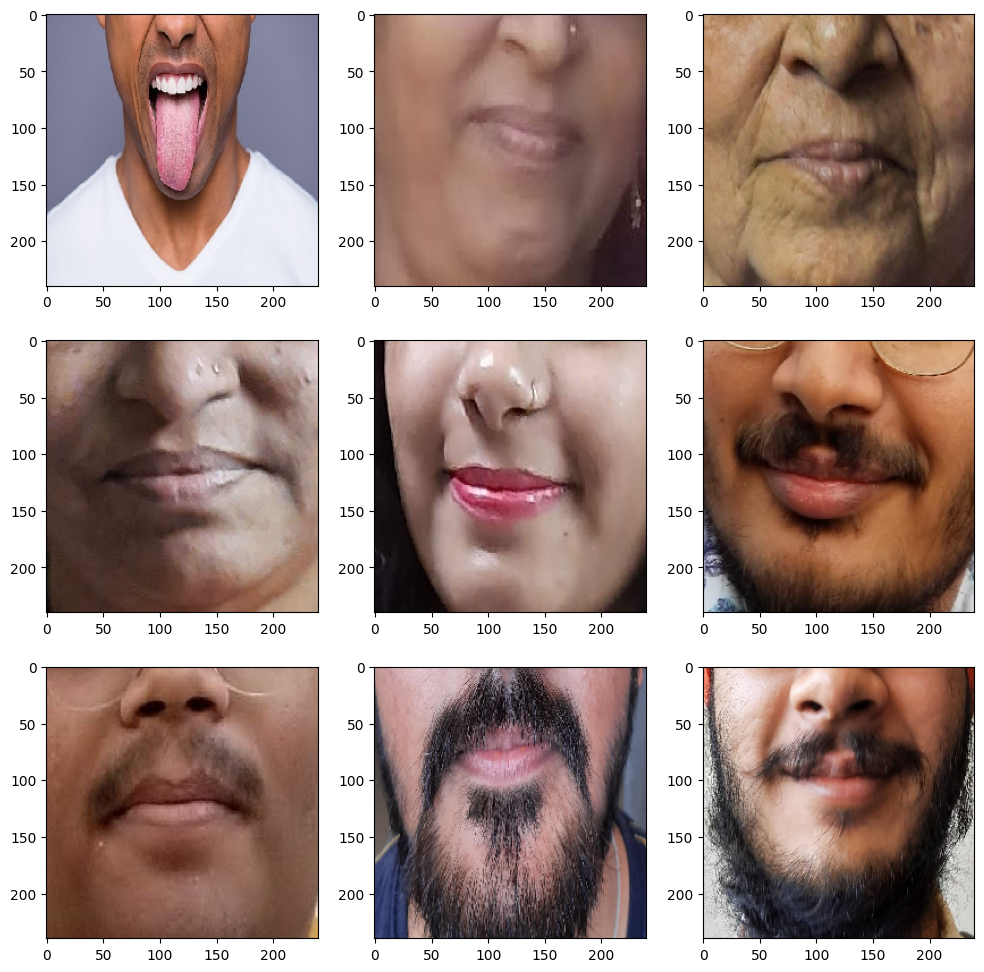

In [9]:
plot_state("non-cancer")

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [11]:
# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))


In [12]:
# Freeze the layers of the base model
base_model.trainable = False

In [13]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu',
          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
          bias_regularizer=regularizers.L2(1e-2),
          activity_regularizer=regularizers.L2(1e-3))(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

In [14]:
# Define the model
model = Model(inputs=base_model.input, outputs=output_layer)

In [15]:
# Compile the model
model.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)


In [16]:
# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 246, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 120, 120, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [17]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [18]:
# Train the model
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    class_weight=class_weights_dict,
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/20
4/4 [==============================] - 14s 3s/step - loss: 4.3305 - accuracy: 0.6190 - val_loss: 3.9198 - val_accuracy: 0.8148
Epoch 2/20
4/4 [==============================] - 11s 3s/step - loss: 3.7594 - accuracy: 0.8857 - val_loss: 3.6755 - val_accuracy: 0.8889
Epoch 3/20
4/4 [==============================] - 12s 3s/step - loss: 3.4744 - accuracy: 0.9238 - val_loss: 3.4366 - val_accuracy: 0.8889
Epoch 4/20
4/4 [==============================] - 15s 4s/step - loss: 3.1859 - accuracy: 0.9333 - val_loss: 3.2093 - val_accuracy: 0.8889
Epoch 5/20
4/4 [==============================] - 16s 4s/step - loss: 2.9815 - accuracy: 0.9429 - val_loss: 3.0048 - val_accuracy: 0.8889
Epoch 6/20
4/4 [==============================] - 16s 4s/step - loss: 2.7933 - accuracy: 0.9524 - val_loss: 2.7938 - val_accuracy: 0.9259
Epoch 7/20
4/4 [==============================] - 13s 3s/step - loss: 2.6141 - accuracy: 0.9714 - val_loss: 2.6147 - val_accuracy: 0.9259
Epoch 8/20
4/4 [==================

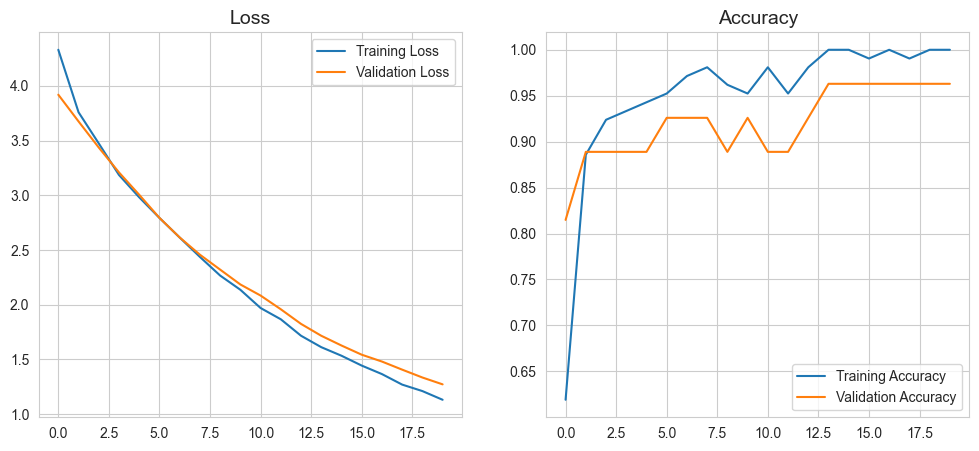

In [19]:
# Plot training history
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss', fontsize=14)
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy', fontsize=14)
ax2.legend()


In [20]:
fig.suptitle('Optimizer: Adam', fontsize=16)
plt.show()

In [21]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)


1/1 [==============================] - 2s 2s/step - loss: 1.2716 - accuracy: 0.9630


In [22]:
# Print the accuracy
print('The accuracy of the ResNet model is {:.2f}%!'.format(test_accuracy * 100))

The accuracy of the ResNet model is 96.30%!


In [23]:
# Predict and plot confusion matrix
predictions = model.predict(x_test)
y_pred = (predictions >= 0.5).astype(int)

def plot_confusion_matrix_enhanced(cm, classes, title='Confusion Matrix', cmap='viridis'):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm_norm, index=classes, columns=classes)
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap=cmap, vmin=0, vmax=1)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

1/1 [==============================] - 3s 3s/step


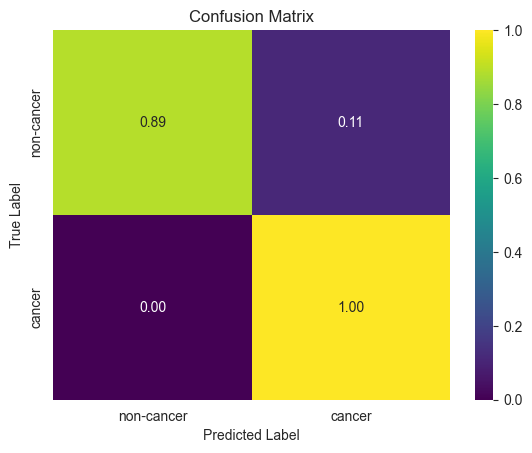

In [24]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix_enhanced(cnf_matrix, classes=["non-cancer", "cancer"])


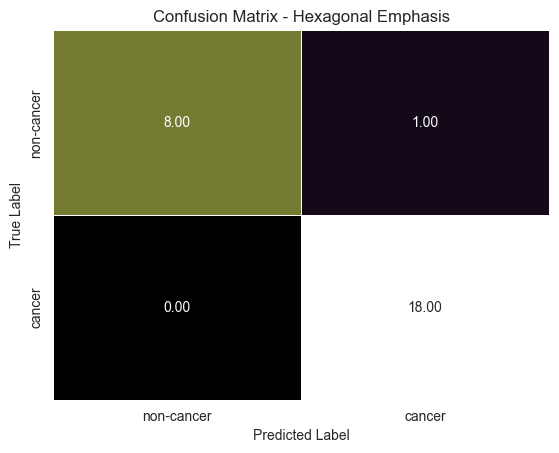

In [25]:
# Hexagonal confusion matrix visualization
mask = np.triu(np.ones_like(cnf_matrix, dtype=bool)) & np.tril(np.ones_like(cnf_matrix, dtype=bool), k=-1)
sns.heatmap(cnf_matrix, annot=True, fmt='.2f', cmap='cubehelix', mask=mask, linewidths=0.5, cbar=False,
            xticklabels=["non-cancer", "cancer"], yticklabels=["non-cancer", "cancer"])
plt.title('Confusion Matrix - Hexagonal Emphasis')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#prediction

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

In [27]:
# Function to load and preprocess a single image for ResNet
def load_and_preprocess_image(image_path, target_size=(240, 240)):
    """Load and preprocess an image."""
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = preprocess_input(image)  # Preprocess the image as per ResNet requirements
    return image

In [28]:
# Function to make a prediction using a ResNet model
def predict_cancer(model, image_path):
    """Predict if an image is cancerous or non-cancerous."""
    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)
    
    # Make a prediction
    prediction = model.predict(image)
    
    # Convert prediction to label
    label = "cancer" if prediction >= 0.5 else "non-cancer"
    confidence = prediction[0][0] if label == "cancer" else 1 - prediction[0][0]
    
    return label, confidence

In [29]:
model.save("Resnet.h5")

# Path to the saved model
model_path = "Resnet.h5"  # Replace with the actual path to your saved model
modelpre = load_model(model_path)